## Scenery Classification

In [1]:
# Set Parameters

# Batch Size for all Datasets
BATCH_SIZE = 256

# Maximum number of Epochs for Training
EPOCHS = 20


In [2]:
# Import Modules
import os
import pandas as pd
import tensorflow as tf
import keras.layers as layers
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.models import Sequential
from matplotlib.image import imread
from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


#### Get Dataset from Kaggle

In [3]:
# Download Dataset
!mkdir dataset
%cd dataset
!kaggle datasets download -d puneet6060/intel-image-classification
clear_output()


In [4]:
# Unzip Dataset
!tar -xf intel-image-classification.zip


In [5]:
# Delete Unwanted Files
!del intel-image-classification.zip
!rmdir /s/q seg_pred
%cd ..
clear_output()


#### Loading FilePaths in Pandas DataFrame

In [6]:
def filepaths_to_dataframe(path):
    labels = []
    file_names = []
    directories = os.listdir(path)
    for directory in directories:
        files = os.listdir(f'{path}/{directory}')
        for file in files:
            labels.append(directory)
            file_names.append(f'{path}/{directory}/{file}')

    labels = pd.Series(data=labels, name='label')
    file_names = pd.Series(data=file_names, name='file_name')

    return pd.concat([labels, file_names], axis=1)


train_val_df = filepaths_to_dataframe('dataset/seg_train/seg_train')
test_df = filepaths_to_dataframe('dataset/seg_test/seg_test')


#### Vizualizing Some Data

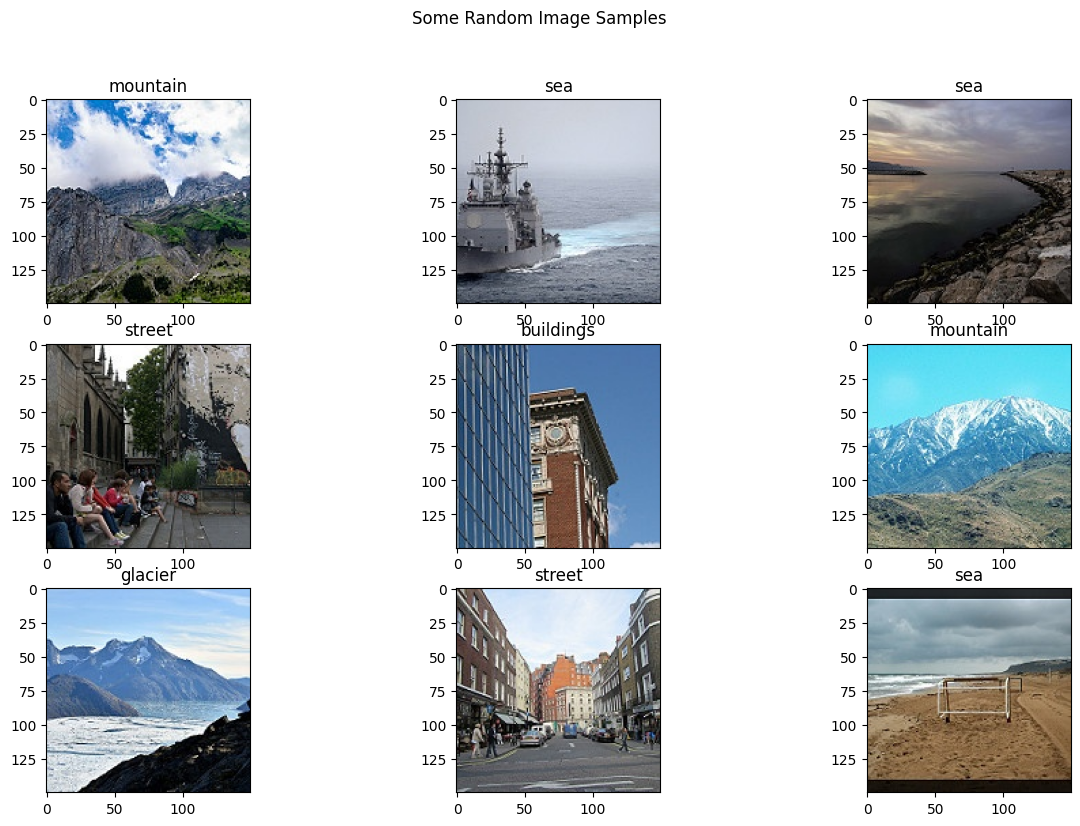

In [7]:
# Vizualize some random images
images = train_val_df.sample(n=9)
fig, ax = plt.subplots(3, 3, figsize=(15, 9))
fig.suptitle('Some Random Image Samples')
for i in range(3):
    for j in range(3):
        k = 3 * i + j
        img = imread(images.iloc[k, 1])
        ax[i][j].imshow(img)
        ax[i][j].set_title(images.iloc[k, 0])


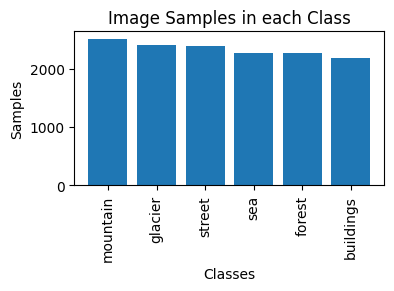

In [8]:
# Vizualize counts of classes
data = train_val_df['label'].value_counts()

fig, ax = plt.subplots(figsize=(4, 2))
ax.set_xlabel('Classes')
ax.set_ylabel('Samples')
ax.set_title('Image Samples in each Class')
ax.bar(data.index, data)
ax.tick_params(axis='x', labelrotation=90)


#### Setting Up Data

In [9]:
# Label Encoding
encoder = LabelEncoder().fit(train_val_df['label'].unique())
train_val_df['label'] = encoder.transform(train_val_df['label'])
test_df['label'] = encoder.transform(test_df['label'])

# Saving encoder data for Web Application
enc_file = open('encoder_data.txt', 'w')
for cls in encoder.classes_:
    enc_file.write(cls+'\n')
enc_file.close()


In [10]:
# Splitting training dataframe into training and validation dataset
train_df, val_df = train_test_split(train_val_df, test_size=0.2)


In [11]:
# Creating Dataset
def dataframe_to_dataset(df):
    ds = tf.data.Dataset.from_tensor_slices((df['file_name'], df['label']))
    ds = ds.map(lambda x, y: (tf.io.read_file(x), y), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    ds = ds.map(lambda x, y: (tf.image.decode_jpeg(x, channels=3), y), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    ds = ds.map(lambda x, y: (tf.image.resize(x, (150, 150)), y), num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    ds = ds.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)

    # Optimize Performance
    ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds


train_ds = dataframe_to_dataset(train_df)
val_ds = dataframe_to_dataset(val_df)
test_ds = dataframe_to_dataset(test_df)


#### Modelling

In [12]:
# Preprocessing Layers
scaling_layer = layers.Rescaling(1.0/255, input_shape=(150, 150, 3))


In [13]:
# Build Model
model = Sequential([scaling_layer,
                    layers.Conv2D(16, kernel_size=(3, 3)),
                    layers.BatchNormalization(),
                    layers.LeakyReLU(),

                    layers.Conv2D(32, kernel_size=(3, 3)),
                    layers.BatchNormalization(),
                    layers.LeakyReLU(),
                    layers.MaxPooling2D(5, 5),

                    layers.Conv2D(64, kernel_size=(3, 3)),
                    layers.BatchNormalization(),
                    layers.LeakyReLU(),

                    layers.Conv2D(128, kernel_size=(3, 3)),
                    layers.BatchNormalization(),
                    layers.LeakyReLU(),
                    layers.MaxPooling2D(5, 5),

                    layers.Flatten(),

                    layers.Dense(64),
                    layers.Dropout(rate=0.2),
                    layers.BatchNormalization(),
                    layers.LeakyReLU(),

                    layers.Dense(32),
                    layers.Dropout(rate=0.2),
                    layers.BatchNormalization(),
                    layers.LeakyReLU(),

                    layers.Dense(16),
                    layers.Dropout(rate=0.2),
                    layers.BatchNormalization(),
                    layers.LeakyReLU(),

                    layers.Dense(6, activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])


In [14]:
# Training Model
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=2)


Epoch 1/20
44/44 - 20s - loss: 1.2754 - accuracy: 0.5532 - val_loss: 1.9222 - val_accuracy: 0.2358 - 20s/epoch - 466ms/step
Epoch 2/20
44/44 - 12s - loss: 0.9260 - accuracy: 0.7254 - val_loss: 2.1628 - val_accuracy: 0.2052 - 12s/epoch - 266ms/step
Epoch 3/20
44/44 - 12s - loss: 0.7574 - accuracy: 0.7772 - val_loss: 2.5941 - val_accuracy: 0.2558 - 12s/epoch - 265ms/step
Epoch 4/20
44/44 - 12s - loss: 0.6469 - accuracy: 0.8052 - val_loss: 2.4082 - val_accuracy: 0.2683 - 12s/epoch - 265ms/step
Epoch 5/20
44/44 - 12s - loss: 0.5723 - accuracy: 0.8248 - val_loss: 2.0756 - val_accuracy: 0.2900 - 12s/epoch - 265ms/step
Epoch 6/20
44/44 - 12s - loss: 0.5208 - accuracy: 0.8425 - val_loss: 1.5207 - val_accuracy: 0.4524 - 12s/epoch - 266ms/step
Epoch 7/20
44/44 - 12s - loss: 0.4683 - accuracy: 0.8570 - val_loss: 1.5426 - val_accuracy: 0.4478 - 12s/epoch - 265ms/step
Epoch 8/20
44/44 - 12s - loss: 0.4218 - accuracy: 0.8685 - val_loss: 0.8473 - val_accuracy: 0.6922 - 12s/epoch - 266ms/step
Epoch 9/

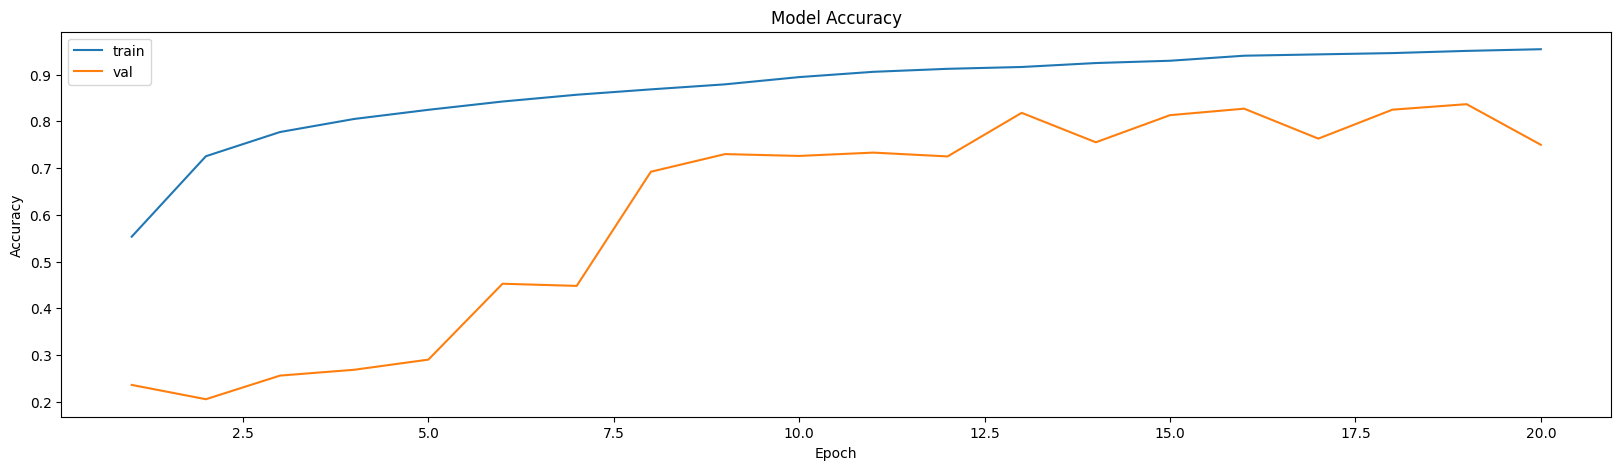

In [15]:
# Plot the training history
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.plot(range(1, len(history.history['accuracy'])+1), history.history['accuracy'], label='train')
ax.plot(range(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], label='val')
_ = ax.legend()


#### Model Evaluation

In [16]:
# Model Accuracy on Test Data
score = model.evaluate(test_ds)
print(f'Accuracy over the test set: {round((score[1]*100), 2)}%')


12/12 [==============================] - 3s 203ms/step - loss: 1.0283 - accuracy: 0.7310
Accuracy over the test set: 73.1%


In [17]:
model.save('model.h5')
